# Contextual grounding

In this notebook, we'll build on the guardrails from the first notebook and add a contextual grounding check to reduced hallucinations.

## Scenario

As a reminder, we are building a chatbot for a city government. This chatbot will answer questions about the community.

In the first notebook, we used guardrails to prevent the chatbot from answering specific real estate questions about property values or whether a particular property should be bought or sold.

Now we'll add a grounding element to make sure that the chatbot is providing accurate, up-to-date information based on references we provide. Specifically, we have a PDF that has a municipal park schedule that the chatbot can use to answer questions.

## Prerequisites

The prerequisites are the same as for the first notebook.

## Creating the Bedrock Guardrail

In [1]:
import boto3

client = boto3.client('bedrock')

In [2]:
import time
unique_id = str(round(time.time()))
create_response = client.create_guardrail(
    name=f"real-estate-advice-with-grounding-{unique_id}",
    description='Prevents the our model from providing real estate advice.',
    topicPolicyConfig={
        'topicsConfig': [
            {
                'name': 'Real Estate Advice',
                'definition': 'Providing advice or recommendations about real estate values or whether a specific property should be bought or sold.',
                'examples': [
                    'Is the real estate market in this neighborhood hot right now?',
                    'Is this house worth that much?',
                    'Should I sell now or wait until interest rates go down?',
                ],
                'type': 'DENY'
            }
        ]
    },
    contentPolicyConfig={
        'filtersConfig': [
            {
                'type': 'SEXUAL',
                'inputStrength': 'HIGH',
                'outputStrength': 'HIGH'
            },
            {
                'type': 'VIOLENCE',
                'inputStrength': 'HIGH',
                'outputStrength': 'HIGH'
            },
            {
                'type': 'HATE',
                'inputStrength': 'HIGH',
                'outputStrength': 'HIGH'
            },
            {
                'type': 'INSULTS',
                'inputStrength': 'HIGH',
                'outputStrength': 'HIGH'
            },
            {
                'type': 'MISCONDUCT',
                'inputStrength': 'HIGH',
                'outputStrength': 'HIGH'
            },
            {
                'type': 'PROMPT_ATTACK',
                'inputStrength': 'HIGH',
                'outputStrength': 'NONE'
            }
        ]
    },
    wordPolicyConfig={
        'wordsConfig': [
            {'text': 'real estate advice'},
            {'text': 'good time to sell'},
            {'text': 'good time to buy'},
            {'text': 'real estate agent recommendations'}
        ],
        'managedWordListsConfig': [
            {'type': 'PROFANITY'}
        ]
    },
    sensitiveInformationPolicyConfig={
        'piiEntitiesConfig': [
            {'type': 'EMAIL', 'action': 'ANONYMIZE'},
            {'type': 'PHONE', 'action': 'ANONYMIZE'},
            {'type': 'NAME', 'action': 'ANONYMIZE'},
            {'type': 'US_SOCIAL_SECURITY_NUMBER', 'action': 'BLOCK'},
            {'type': 'US_BANK_ACCOUNT_NUMBER', 'action': 'BLOCK'},
            {'type': 'CREDIT_DEBIT_CARD_NUMBER', 'action': 'BLOCK'}
        ],
        'regexesConfig': [
            {
                'name': 'Account Number',
                'description': 'Matches account numbers in the format XXXXXX1234',
                'pattern': r'\b\d{6}\d{4}\b',
                'action': 'ANONYMIZE'
            }
        ]
    },
    contextualGroundingPolicyConfig={
        'filtersConfig': [
            {
                'type': 'GROUNDING',
                'threshold': 0.75
            },
            {
                'type': 'RELEVANCE',
                'threshold': 0.75
            }
        ]
    },
    blockedInputMessaging="""I can provide general info about the community, but can't fully address your request here. For personalized help or detailed questions, please contact our customer service team directly. For security reasons, avoid sharing sensitive information through this channel. If you have a general HOA question, feel free to ask without including personal details. """,
    blockedOutputsMessaging="""I can provide general info about the community, but can't fully address your request here. For personalized help or detailed questions, please contact our customer service team directly. For security reasons, avoid sharing sensitive information through this channel. If you have a general HOA question, feel free to ask without including personal details. """,
    tags=[
        {'key': 'purpose', 'value': 'real-estate-advice-prevention'},
        {'key': 'environment', 'value': 'production'}
    ]
)

print(create_response)

{'ResponseMetadata': {'RequestId': 'd092a2a9-af9a-48c1-9b06-092949eb0a1b', 'HTTPStatusCode': 202, 'HTTPHeaders': {'date': 'Sun, 24 Aug 2025 15:05:26 GMT', 'content-type': 'application/json', 'content-length': '172', 'connection': 'keep-alive', 'x-amzn-requestid': 'd092a2a9-af9a-48c1-9b06-092949eb0a1b'}, 'RetryAttempts': 0}, 'guardrailId': 'm77qat26bkm3', 'guardrailArn': 'arn:aws:bedrock:us-west-2:102165494304:guardrail/m77qat26bkm3', 'version': 'DRAFT', 'createdAt': datetime.datetime(2025, 8, 24, 15, 5, 26, 474350, tzinfo=tzutc())}


In [3]:
version_response = client.create_guardrail_version(
    guardrailIdentifier=create_response['guardrailId'],
    description='Version of Guardrail'
)

In [4]:
guardrail_id = create_response['guardrailId']
guardrail_id

'm77qat26bkm3'

In [5]:
guardrail_version = version_response['version']
guardrail_version

'1'

## Using the guardrail

We will again use the guardrail to inspect the user's input prompt and the response from the LLM.

### Setup

In [6]:
bedrock_runtime = boto3.client('bedrock-runtime')

In [7]:
model_id = 'us.amazon.nova-pro-v1:0'

In [8]:
def chat(messages, system_prompts, model_id = model_id):

    # Send the message.
    response = bedrock_runtime.converse(
        modelId=model_id,
        messages=messages,
        system=system_prompts,
    )

    # Log token usage.
    token_usage = response['usage']
    output_message = response['output']['message']

    return output_message['content'][0]['text'], token_usage['inputTokens'], token_usage['outputTokens']


In [9]:
def analyze_text(query, source, guard_content, guardrail_id, guardrail_version, grounding_source = None):
    try:
        content = [
            {
                "text": {
                    "text": query,
                    "qualifiers": ["query"]
                }
            },
            {
                "text": {
                    "text": guard_content,
                    "qualifiers": ["guard_content"]
                }
            }
        ]

        if grounding_source is not None:
            content.append(
                {
                    "text": {
                        "text": grounding_source,
                        "qualifiers": ["grounding_source"]
                    }
                }
            )

        response = bedrock_runtime.apply_guardrail(
            guardrailIdentifier=guardrail_id,
            guardrailVersion=guardrail_version,
            source=source,
            content=content
        )
        
        action = response.get("action", "")
        if action == "NONE":
            return True, "", response
        elif action == "GUARDRAIL_INTERVENED":
            message = response.get("outputs", [{}])[0].get("text", "Guardrail intervened")
            return False, message, response
        else:
            return False, f"Unknown action: {action}", response
    except Exception as e:
        return False, f"Error applying guardrail: {e}", None

In [10]:
def calculate_guardrail_cost(guardrail_response):
    usage = guardrail_response['usage']

    content_filter_cost = 0.15 # per 1000 units
    content_filter_image_cost = 0.00075 # per image
    denied_topic_cost = 0.15 # per 1000 units
    sensitive_filter_cost = 0.1 # per 1000 units
    grounding_cost = 0.1 # per 1000 units
    ar_cost = 0.17 # per 1000 units per policy
    word_cost = 0 

    cost = usage['topicPolicyUnits'] * denied_topic_cost / 1000.0 + \
        usage['contentPolicyUnits'] * content_filter_cost / 1000.0 + \
        usage['wordPolicyUnits'] * word_cost + \
        usage['sensitiveInformationPolicyUnits'] * sensitive_filter_cost / 1000.0 + \
        usage['contextualGroundingPolicyUnits'] * grounding_cost / 1000.0 + \
        usage['contentPolicyImageUnits'] * content_filter_image_cost + \
        usage['automatedReasoningPolicyUnits'] * ar_cost  / 1000.0 * usage['automatedReasoningPolicies']

    return cost

In [11]:
# convenience method to calculate Nova Pro cost, not considering prompt caching
def calculate_llm_cost(tokens_in, tokens_out):
    nova_in_cost = 0.0008 # per thousand tokens
    nova_out_cost = 0.0032 # per thousand tokens

    cost = nova_in_cost * tokens_in / 1000.0 + \
        nova_out_cost * tokens_out / 1000.0
    
    return cost

In [12]:
input_document_path = 'calendar.pdf'
with open(input_document_path, 'rb') as input_document_file:
    input_document = input_document_file.read()

### Inspect the input

In [13]:
system_prompts = [{"text": "You are a helpful assistant for our city. Your job is to inform and assist residents. You cannot provide any real estate advice. You can answer questions about the city calendar only using the provided document."}]
message_1 = {
    "role": "user",
    "content": [
        {"text": "When is the next bandshell concert?"},
        {
            "document": {
                "name": "Calendar",
                "format": "pdf",
                "source": {
                    "bytes": input_document
                }
            }
        }
    ]
}

In [14]:
query = message_1['content'][0]['text'] 
prompt_passed, prompt_message, gr_response = analyze_text(
     query,
     "INPUT", 
     query, 
     guardrail_id,
     guardrail_version)

In [15]:
print(f"Prompt passed: {prompt_passed}")

Prompt passed: True


In [16]:
print(f"Guardrail message: {prompt_message}")

Guardrail message: 


In [17]:
calculate_guardrail_cost(gr_response)

0.00039999999999999996

### Invoke the LLM

In [18]:
r, t_in, t_out = chat([message_1], system_prompts)

In [19]:
print(f"Response: {r}")
print(f"Tokens: {t_in}, {t_out}")

Response: The next bandshell concert is on Wednesday, August 20, 2025 at 4:00 PM at Golden Gate Bandshell.
Tokens: 24199, 32


In [20]:
calculate_llm_cost(t_in, t_out)

0.0194616

### Inspect the output

We'll provide the contents of the calendar PDF as grounding text.

In [21]:
import PyPDF2
def extract_text_from_pdf(pdf_path):
    """Extract text from a PDF file."""
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ""
        for page in reader.pages:
            text += page.extract_text()
    return text

In [22]:
grounding_text = extract_text_from_pdf('calendar.pdf')

In [23]:
prompt_passed, prompt_message, gr_response = analyze_text(
     query,
     "OUTPUT", 
     r, 
     guardrail_id,
     guardrail_version,
     grounding_text)

In [24]:
print(f"Prompt passed: {prompt_passed}")
print(f"Guardrail message: {prompt_message}")

Prompt passed: True
Guardrail message: 


In [25]:
calculate_guardrail_cost(gr_response)

0.0025000000000000005

## Conclusion

This notebook adds a contextual grounding check to our chatbot.

As written, the costs are:

* LLM call - $0.0194616
* Input guardrail - $0.00039999999999999996
* Output guardrail - $0.0025000000000000005

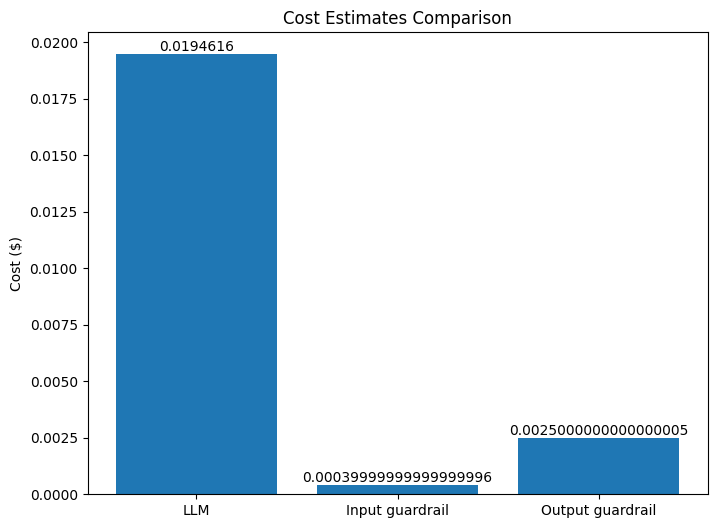

In [26]:
import matplotlib.pyplot as plt

estimates = [0.0194616, 0.00039999999999999996, 0.0025000000000000005]  
labels = ["LLM", "Input guardrail", "Output guardrail"]

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(labels, estimates)

# Customize the chart
plt.title('Cost Estimates Comparison')
plt.ylabel('Cost ($)')

# Add value labels on top of each bar
for i, v in enumerate(estimates):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Display the chart
plt.show()